<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/LearningWithoutForgetting-v1_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from copy import copy
from copy import deepcopy

#### Cloning the Git repository

In [3]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

In [4]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.lwf import LearningWithoutForgetting

#### Downloading data from Cifar100

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [6]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified


classe: 90


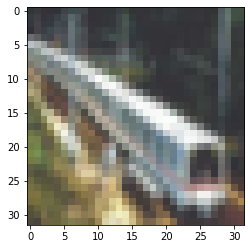

In [7]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

## Learning Without Forgetting

### Defining hyperparameters according to iCarl paper

In [9]:
# Settings
DEVICE = 'cuda'
NUM_CLASSES = 100         # Total number of classes
VAL_SIZE = 0.2            # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128          # Batch size
LR = 2                    # Initial learning rate
                       
MOMENTUM = 0.9            # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5       # Weight decay from iCaRL

RANDOM_SEED = [10]  # Random seeds defining the runs of every method
                          # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70           # Total number of training epochs
MILESTONES = [49, 63]     # Step down policy from iCaRL (MultiStepLR)
                          # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2               # Gamma factor from iCaRL (1/5)

### Definition of `do_shuffle` and `do_group_classes`
`do_shuffle` and `do_group_classes` are two functions that rispectively shuffle data downloaded from Cifar100 and get the incremental classes division for the incremental learning phase.



In [10]:
def do_shuffle(train_d, test_d):
  train_d.__shuffle_seed__(RANDOM_SEED[run])
  test_d.__shuffle_seed__(RANDOM_SEED[run])
  return train_d, test_d

def do_group_classes(train_d, test_d):
  indexes_train_data = train_d.__incremental_indexes__(True)
  indexes_test_data = test_d.__incremental_indexes__(False)


  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]
  for i in range(10):
    train_dataset = Subset(train_d, indexes_train_data[i])
    train_set, val_set = torch.utils.data.random_split(train_dataset, 
                                                       [int((1-VAL_SIZE)*len(indexes_train_data[i])), int(VAL_SIZE*len(indexes_train_data[i]))])
    tmp_dl = DataLoader(train_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    train_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi 
    tmp_dl = DataLoader(val_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    val_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi


    test_dataset = Subset(test_d, indexes_test_data[i])
    tmp_dl = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    test_dataloader[i] = copy(tmp_dl) # classi incrementali: 0:0-9, 1:0-19, 2:0-29, ..., 9:0-99
    
  return train_dataloader, val_dataloader, test_dataloader

### Going on with the model
This is the main LWF step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.

In [11]:
logs = [[] for i in range(len(RANDOM_SEED))]
best_net_tot_classes = [None for i in range(len(RANDOM_SEED))]


for run in range(len(RANDOM_SEED)):
  random.seed(RANDOM_SEED[run])
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")

  #shuffle data
  train_data, test_data = do_shuffle(train_data, test_data)
  #get dataloader separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl = do_group_classes(train_data, test_data)

  #create the resnet
  net = resnet32()

  #define criterion, parameters, optimizer and scheduler
  criterion = nn.BCEWithLogitsLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, 
                        lr=LR, 
                        momentum=MOMENTUM, 
                        weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                             milestones=MILESTONES, 
                                             gamma=GAMMA)
  
  trainer = LearningWithoutForgetting(DEVICE,
                                      net,
                                      LR,
                                      MOMENTUM,
                                      WEIGHT_DECAY,
                                      MILESTONES,
                                      GAMMA,
                                      train_dl,
                                      val_dl,
                                      test_dl)

  #train and evaluate the model
  logs[run] = trainer.train_model(NUM_EPOCHS)

  best_net_tot_classes[run] = deepcopy(trainer.best_net)

  print("#################################")
  print("")
  print("")

#################################
Radom seed: 10



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/70 LR: [2]
Validation accuracy on group 1/10: 0.10
Best model updated

Epoch 2/70 LR: [2]
Validation accuracy on group 1/10: 0.12
Best model updated

Epoch 3/70 LR: [2]
Validation accuracy on group 1/10: 0.12

Epoch 4/70 LR: [2]
Validation accuracy on group 1/10: 0.15
Best model updated

Epoch 5/70 LR: [2]
Validation accuracy on group 1/10: 0.12

Epoch 6/70 LR: [2]
Validation accuracy on group 1/10: 0.11

Epoch 7/70 LR: [2]
Validation accuracy on group 1/10: 0.12

Epoch 8/70 LR: [2]
Validation accuracy on group 1/10: 0.13

Epoch 9/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 10/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 11/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 12/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epoch 13/70 LR: [2]
Validation accuracy on group 1/10: 0.17

Epoch 14/70 LR: [2]
Validation accuracy on group 1/10: 0.17
Best model updated

Epo

### Store logs in more usable dtype

In [12]:
train_loss = [[logs[run_i]['group_train_loss'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
train_accuracy = [[logs[run_i]['group_train_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_loss = [[logs[run_i]['val_losses'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_accuracy = [[logs[run_i]['val_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
test_accuracy = [[logs[run_i]['test_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]

### Save the model

#### Saving logs in JSON files

In [13]:
import json

with open('states/LWF_train_loss.json', 'w') as a:
  json.dump(train_loss, a)
a.close
with open('states/LWF_train_accuracy.json', 'w') as b:
  json.dump(train_accuracy, b)
b.close

with open('states/LWF_val_loss.json', 'w') as c:
  json.dump(val_loss, c)
c.close  

with open('states/LWF_val_accuracy.json', 'w') as d:
  json.dump(val_accuracy, d)
d.close

with open('states/LWF_test_accuracy.json', 'w') as e:
  json.dump(test_accuracy, e)
e.close


<function TextIOWrapper.close>

#### Saving best resnet on 100 classes for each seed

In [14]:
for i in range(len(RANDOM_SEED)):
  torch.save(best_net_tot_classes[i].state_dict(), "states/LWF_bestnet_seed[{}]".format(RANDOM_SEED[i]))

### Print some graphs

In [15]:
from data.utils_plot import plot_train_val, plot_test_accuracies, plot_confusion_matrix

In [16]:
train_loss = np.array(train_loss)
train_accuracy = np.array(train_accuracy)
val_loss = np.array(val_loss)
val_accuracy = np.array(val_accuracy)
test_accuracy = np.array(test_accuracy)

train_loss_stats = np.array([train_loss.mean(0), train_loss.std(0)]).transpose()
train_accuracy_stats = np.array([train_accuracy.mean(0), train_accuracy.std(0)]).transpose()
val_loss_stats = np.array([val_loss.mean(0), val_loss.std(0)]).transpose()
val_accuracy_stats = np.array([val_accuracy.mean(0), val_accuracy.std(0)]).transpose()
test_accuracy_stats = np.array([test_accuracy.mean(0), test_accuracy.std(0)]).transpose()

#### Train validation loss

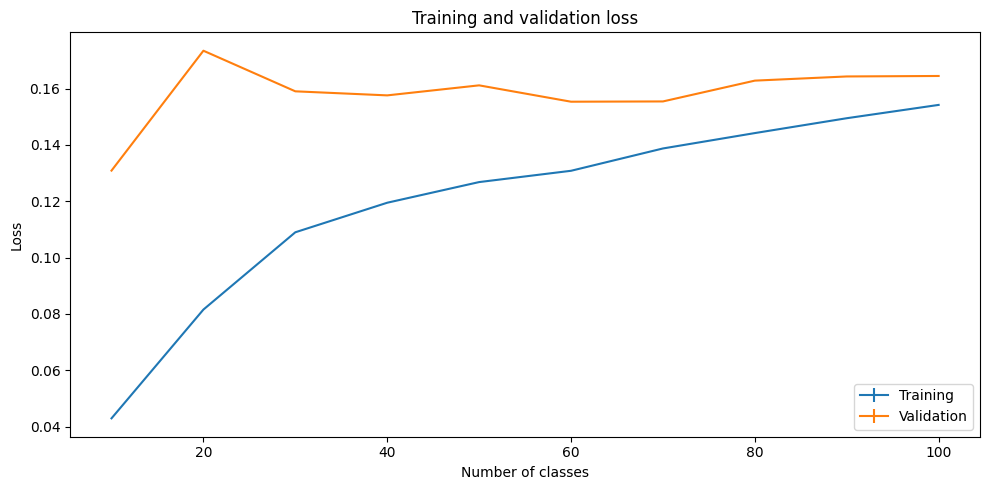

In [17]:
plot_train_val(train_loss_stats, val_loss_stats, loss = True)

#### Train validation accuracy

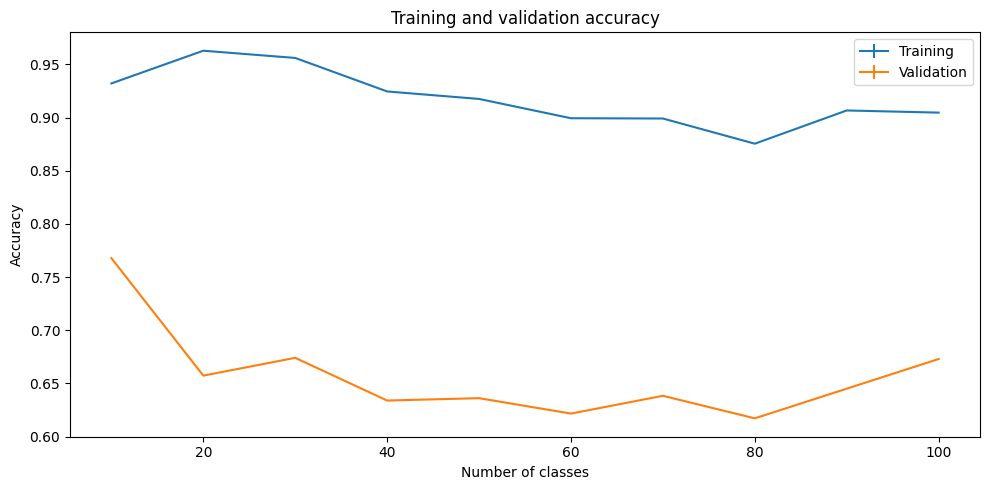

In [18]:
plot_train_val(train_accuracy_stats, val_accuracy_stats, loss = False)

#### Test accuracy

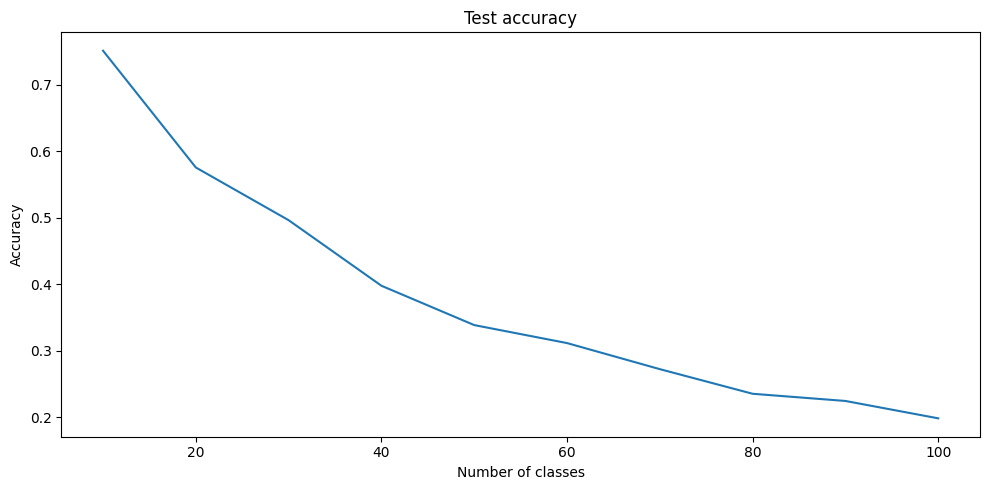

In [19]:
plot_test_accuracies(test_accuracy_stats)

#### Confusion Matrix

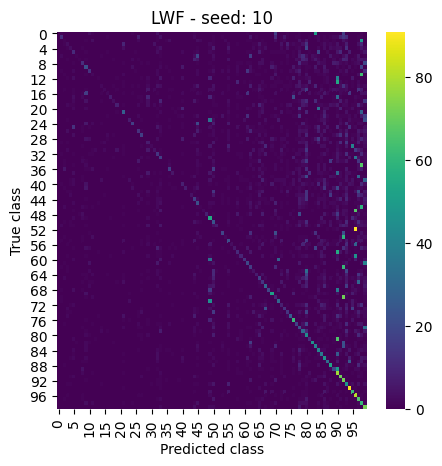

In [20]:
for run in range(len(RANDOM_SEED)):
  targets = logs[run]['true_labels'].cpu().data.numpy()
  preds = logs[run]['predictions'].cpu().data.numpy()

  plot_confusion_matrix(targets, preds, RANDOM_SEED[run], 'LWF')

### Load modello da spostare

In [ ]:
model2 = resnet32()

in_features = model2.fc.in_features  # size of each input sample
out_features = model2.fc.out_features  # size of each output sample
weight = model2.fc.weight.data
model2.fc = nn.Linear(in_features, 100)
model2.fc.weight.data[:out_features] = weight

In [ ]:
model2.load_state_dict(torch.load("./state"))

In [ ]:
trainer2 = Trainer(DEVICE,
                    model2,
                    LR,
                    MOMENTUM,
                    WEIGHT_DECAY,
                    MILESTONES,
                    GAMMA,
                    train_dl,
                    val_dl,
                    test_dl)

In [ ]:
trainer.best_net = model2.cuda()

#trainer.test()

In [ ]:

#load
f = open('FineTuning_logs.json')
x = json.load(f)